In [1]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import time
import matplotlib.pyplot as plt
from copy import deepcopy
#import torch_xla.core.xla_model as xm

In [2]:
def getData(typ='train',data_folder = '1'):
    
    if typ == 'train':
        main_folder = '/kaggle/input/vesuvius-challenge-ink-detection/train/'
    else:
        main_folder = '/kaggle/input/vesuvius-challenge-ink-detection/test/'

    ps = 256 # patch size
    hps = ps//2 #half patch size    
    
    data = []
        
    im = cv2.imread(main_folder+data_folder+'/surface_volume/00.tif', cv2.IMREAD_GRAYSCALE)
    (h,w) = im.shape

    mask_name = main_folder+data_folder+'/mask.png'    
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    mask = mask/255

    for kh in range((h//hps)+1):

        if (kh+2)*hps > h:
            height_pixs = [h-ps,h] 
        else:
            height_pixs = [kh*hps,(kh+2)*hps]

        for kw in range((w//hps)+1):
            if (kw+2)*hps > w:
                width_pixs = [w-ps,w]
            else:
                width_pixs = [kw*hps,(kw+2)*hps]


            if mask[height_pixs[0]:height_pixs[1],width_pixs[0]:width_pixs[1]].sum() > ps * hps:
                if typ == 'train': 
                    data.append([height_pixs[0],height_pixs[1],width_pixs[0],width_pixs[1]])  
                else:
                    data.append([height_pixs[0],height_pixs[1],width_pixs[0],width_pixs[1]])
    return data

In [3]:
class Loss(nn.Module):

    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, pred, gold):
       # device = xm.xla_device()
        
        pred = pred[0,0,:,:]
        gold = torch.FloatTensor(gold.astype(np.float32)).cuda()
        
        loss = - gold * torch.log(pred + 1e-8) - (1-gold) * torch.log((1-pred) + 1e-8)
    
        return torch.mean(loss)

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channel, first_out_channel):
        super(UNet, self).__init__()
        foc = first_out_channel
        self.b1 = self.createBlock(in_channel, foc)
        self.maxPooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b2 = self.createBlock(foc, foc*2)
        self.maxPooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b3 = self.createBlock(foc*2, foc*4)
        self.maxPooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b4 = self.createBlock(foc*4, foc*8)
        self.convTrans1 = nn.ConvTranspose2d(foc*8, foc*4, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans1.weight)
        self.b5 = self.createBlock(foc*8, foc*4)
        self.convTrans2 = nn.ConvTranspose2d(foc*4, foc*2, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans2.weight)
        self.b6 = self.createBlock(foc*4, foc*2)
        self.convTrans3 = nn.ConvTranspose2d(foc*2, foc, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans3.weight)
        self.b7 = self.createBlock(foc*2, foc)
        self.b8 = nn.Conv2d(in_channels=foc, out_channels=1, kernel_size=1,bias=False)
        torch.nn.init.kaiming_uniform_(self.b8.weight)

    def forward(self,im):
        x1 = self.b1(im) # 1,32,(H,W) 
        x = self.maxPooling1(x1) # 1,32,(1/2)*(H,W) 
        x2 = self.b2(x) # 1,64,(1/2)*(H,W)
        x = self.maxPooling2(x2) # 1,64,(1/4)*(H,W) 
        x3 = self.b3(x) # 1,128,(1/4)*(H,W)
        x = self.maxPooling3(x3) # 1,128,(1/8)*(H,W) 
        x = self.b4(x) # 1,256,(1/8)*(H,W)
        x = self.convTrans1(x) # 1,128,(1/4)*(H,W)
        x = torch.cat((x, x3), dim=1) # 1,256,(1/4)*(H,W)
        x = self.b5(x) # 1,128,(1/4)*(H,W)
        x = self.convTrans2(x) # 1,64,(1/2)*(H,W)
        x = torch.cat((x, x2), dim=1) # 1,128,(1/2)*(H,W)
        x = self.b6(x) # 1,64,(1/2)*(H,W)
        x = self.convTrans3(x) # 1,32,(H,W)
        x = torch.cat((x, x1), dim=1) # 1,64,(H,W)
        x = self.b7(x) # 1,32,(H,W)
        x = self.b8(x)  # 1,1,(H,W)
        x = torch.sigmoid(x)
        return x      

    @staticmethod
    def createBlock(in_chnl, out_chnl):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chnl, out_channels=out_chnl, kernel_size=3, padding=1,bias=False),
            #nn.Dropout(p=0.3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_chnl, out_channels=out_chnl, kernel_size=3, padding=1, bias=False),
            #nn.Dropout(p=0.3),
            nn.ReLU(inplace=True)
            )

In [5]:
in_channel = 65
first_out_channel = 16

In [6]:
######## read images ##############

main_folder = '/kaggle/input/vesuvius-challenge-ink-detection/train/'
df = '1'
    
image_name =main_folder+df+'/surface_volume/00.tif'
image = np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)

for i in range(1,65):
    n=str(i)
    if i < 10:
        n=n.zfill(2)

    image_name =main_folder+df+'/surface_volume/'+n+'.tif'
    image = np.concatenate((image,np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)))

gold_name = main_folder+df+'/inklabels.png'    
label = cv2.imread(gold_name, cv2.IMREAD_GRAYSCALE)
label = label/255

######## end read images ##############
#device = xm.xla_device()

loss_func = Loss()
model = UNet(in_channel,first_out_channel).cuda()
optimizer = optim.Adam(model.parameters(),lr=0.00001)

trn, val = data.random_split(getData(typ='train',data_folder = '1'), [0.7,0.3])
train_loader = data.DataLoader(trn ,batch_size=1, shuffle=True)
val_loader = data.DataLoader(val ,batch_size=1)

losses = []
val_losses = []
min_val_loss = np.Inf
l = len(train_loader)
tot_time_passed = 0
patience = 20
cnter = 0

for epoch in range(10000):
    start_time = time.time()
    loss_sum = 0
    model.train()
    for inpt_pixs in train_loader:
        
        inpt = image[:,inpt_pixs[0].item():inpt_pixs[1].item(),inpt_pixs[2].item():inpt_pixs[3].item()]
        inpt = np.expand_dims(inpt,0)
        inpt = torch.FloatTensor(inpt.astype(np.float32))

        output = model(inpt.cuda())

        optimizer.zero_grad()
        loss = loss_func(output,label[inpt_pixs[0].item():inpt_pixs[1].item(),inpt_pixs[2].item():inpt_pixs[3].item()])

        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
        #xm.mark_step()

    trainingLoss = loss_sum / l    
    losses.append(trainingLoss)
    
    ####-----  calculate val loss  -----####
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inpt_pixs in val_loader:
            
            inpt = image[:,inpt_pixs[0].item():inpt_pixs[1].item(),inpt_pixs[2].item():inpt_pixs[3].item()]
            inpt = np.expand_dims(inpt,0)
            inpt = torch.FloatTensor(inpt.astype(np.float32))

            output = model(inpt.cuda())

            val_loss += loss_func(output,label[inpt_pixs[0].item():inpt_pixs[1].item(),inpt_pixs[2].item():inpt_pixs[3].item()])
 
        avrg_val_loss = val_loss.item() / len(val_loader)

        val_losses.append(avrg_val_loss)
    ####----  calculate val loss end ----####
    
    if min_val_loss > avrg_val_loss:
        min_val_loss = avrg_val_loss
        cnter = 0
        weights = deepcopy(model.state_dict())
        used_loss = min_val_loss
    else:
        cnter += 1

    time_passed = time.time() - start_time 
    tot_time_passed = tot_time_passed + time_passed
    print('epoch: ', epoch, '- trn_loss: ', round(trainingLoss,10), '- val_loss: ', 
          round(avrg_val_loss,10), '- counter: ', cnter, '-tot mins: ', 
          round(tot_time_passed/60))

    if cnter >=patience:
        torch.save(weights, '/kaggle/working/weights.pth')
        print('used loss: ', used_loss)
        break

epoch:  0 - trn_loss:  0.5021207458 - val_loss:  0.4803389658 - counter:  0 -tot mins:  0
epoch:  1 - trn_loss:  0.4863491054 - val_loss:  0.4690420566 - counter:  0 -tot mins:  1
epoch:  2 - trn_loss:  0.477442302 - val_loss:  0.4602355394 - counter:  0 -tot mins:  1
epoch:  3 - trn_loss:  0.4723969119 - val_loss:  0.46138206 - counter:  1 -tot mins:  1
epoch:  4 - trn_loss:  0.4688136054 - val_loss:  0.4567769462 - counter:  0 -tot mins:  2
epoch:  5 - trn_loss:  0.4664053262 - val_loss:  0.4629820088 - counter:  1 -tot mins:  2
epoch:  6 - trn_loss:  0.46517008 - val_loss:  0.4465195209 - counter:  0 -tot mins:  2
epoch:  7 - trn_loss:  0.4632225059 - val_loss:  0.4513201274 - counter:  1 -tot mins:  3
epoch:  8 - trn_loss:  0.4618501733 - val_loss:  0.457182205 - counter:  2 -tot mins:  3
epoch:  9 - trn_loss:  0.4618434477 - val_loss:  0.4552505043 - counter:  3 -tot mins:  3
epoch:  10 - trn_loss:  0.4607839453 - val_loss:  0.4472916381 - counter:  4 -tot mins:  4
epoch:  11 - tr

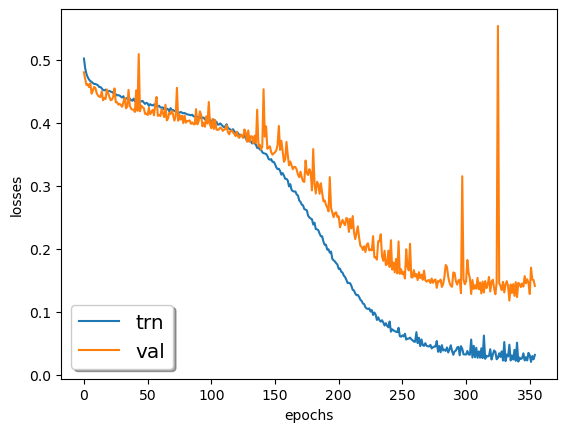

In [7]:
fig, ax = plt.subplots()
plt.xlabel('epochs')
plt.ylabel('losses')
ax.plot(losses, label='trn')
ax.plot(val_losses, label='val')
legend = ax.legend(shadow=True, fontsize='x-large')
plt.show()

In [8]:
######## read images ##############
main_folder = '/kaggle/input/vesuvius-challenge-ink-detection/test/'
df = 'a'
    
image_name =main_folder+df+'/surface_volume/00.tif'
image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
(h,w) = image.shape
image = np.expand_dims(image, axis=0)

for i in range(1,65):
    n=str(i)
    if i < 10:
        n=n.zfill(2)

    image_name =main_folder+df+'/surface_volume/'+n+'.tif'
    image = np.concatenate((image,np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)))

######## end read images ##############
model.load_state_dict(torch.load('/kaggle/working/weights.pth'))

model.eval()
with torch.no_grad():
        
    data = getData(typ='test',data_folder=df)
    
    predWhole_a = np.zeros((h,w), dtype=np.uint8)

    for pixs in data:
        inpt = image[:,pixs[0]:pixs[1],pixs[2]:pixs[3]]
        inpt = np.expand_dims(inpt,0)
        output = model(torch.FloatTensor(inpt).cuda())
        pre_prediction = output.detach().cpu().numpy()[0,0,:,:]
        prediction = np.uint8(np.where(pre_prediction >= 0.5,1,0))
        predWhole_a[pixs[0]:pixs[1],pixs[2]:pixs[3]] = prediction  

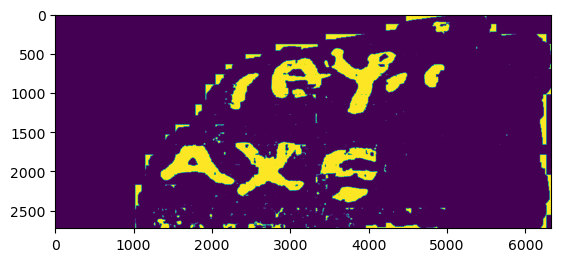

In [9]:
plt.imshow(predWhole_a)

In [10]:
import skimage.segmentation as sg

In [11]:
mask_name = main_folder+df+'/mask.png'    
mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
mask = mask/255

mask_bnd = np.transpose(np.nonzero(sg.find_boundaries(mask, mode='inner').astype(np.uint8)))

In [12]:
for x,y in mask_bnd:
    if x-120 < 0: 
        xs = 0 
    else: 
        xs = x-120
    if x+120 > h: 
        xe = h 
    else: 
        xe = x+120
    if y-120 < 0: 
        ys = 0 
    else: 
        ys = y-120
    if y+120 > w: 
        ye = w 
    else: 
        ye = y+120
    
    predWhole_a[xs:xe,ys:ye] = 0

In [13]:
from skimage import morphology
from scipy.ndimage import label

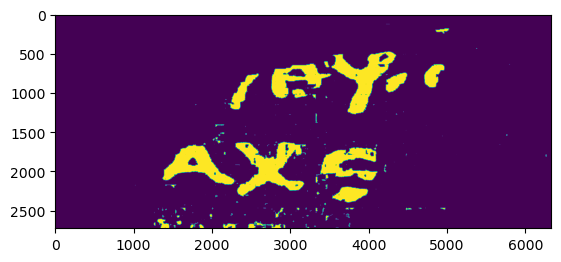

In [14]:
plt.imshow(predWhole_a)

In [15]:
predWhole_a, _ = label(predWhole_a)
predWhole_a = morphology.remove_small_objects(predWhole_a, min_size=1000, connectivity=1)
predWhole_a = np.uint8(np.where(predWhole_a>0,1,0))

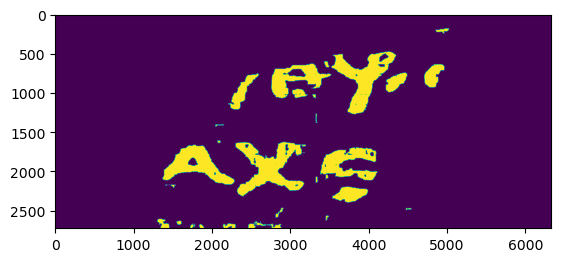

In [16]:
plt.imshow(predWhole_a)

In [17]:
######## read images ##############
main_folder = '/kaggle/input/vesuvius-challenge-ink-detection/test/'
df = 'b'
    
image_name =main_folder+df+'/surface_volume/00.tif'
image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
(h,w) = image.shape
image = np.expand_dims(image, axis=0)

for i in range(1,65):
    n=str(i)
    if i < 10:
        n=n.zfill(2)

    image_name =main_folder+df+'/surface_volume/'+n+'.tif'
    image = np.concatenate((image,np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)))

######## end read images ##############
model.load_state_dict(torch.load('/kaggle/working/weights.pth'))

model.eval()
with torch.no_grad():
        
    data = getData(typ='test',data_folder=df)
    
    predWhole_b = np.zeros((h,w), dtype=np.uint8)

    for pixs in data:
        inpt = image[:,pixs[0]:pixs[1],pixs[2]:pixs[3]]
        inpt = np.expand_dims(inpt,0)
        output = model(torch.FloatTensor(inpt).cuda())
        pre_prediction = output.detach().cpu().numpy()[0,0,:,:]
        prediction = np.uint8(np.where(pre_prediction >= 0.5,1,0))
        predWhole_b[pixs[0]:pixs[1],pixs[2]:pixs[3]] = prediction  

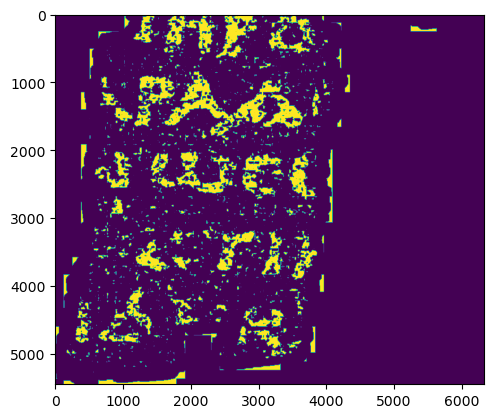

In [18]:
plt.imshow(predWhole_b)

In [19]:
mask_name = main_folder+df+'/mask.png'    
mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
mask = mask/255

mask_bnd = np.transpose(np.nonzero(sg.find_boundaries(mask, mode='inner').astype(np.uint8)))

In [20]:
for x,y in mask_bnd:
    if x-120 < 0: 
        xs = 0 
    else: 
        xs = x-120
    if x+120 > h: 
        xe = h 
    else: 
        xe = x+120
    if y-120 < 0: 
        ys = 0 
    else: 
        ys = y-120
    if y+120 > w: 
        ye = w 
    else: 
        ye = y+120
    
    predWhole_b[xs:xe,ys:ye] = 0

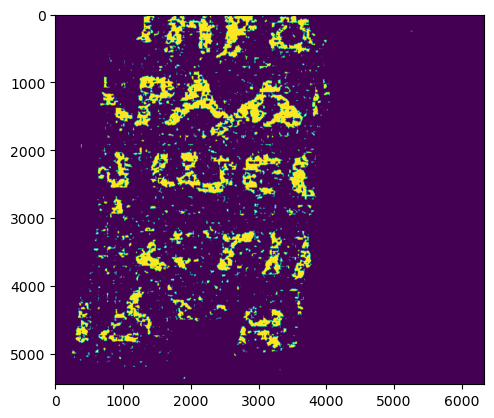

In [21]:
plt.imshow(predWhole_b)

In [22]:
predWhole_b, _ = label(predWhole_b)
predWhole_b = morphology.remove_small_objects(predWhole_b, min_size=1000, connectivity=1)
predWhole_b = np.uint8(np.where(predWhole_b>0,1,0))

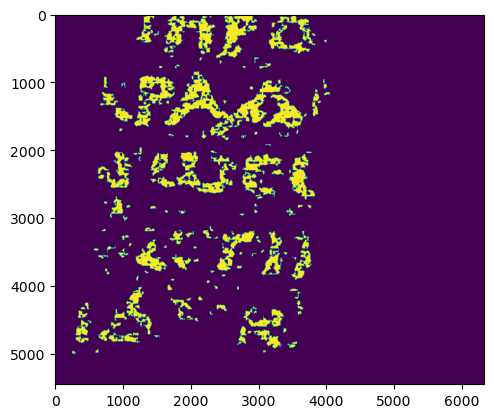

In [23]:
plt.imshow(predWhole_b)

In [24]:
def rle(output):
    pixels = output.flatten().astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [25]:
#reset -f

In [26]:
print("Id,Predicted\na," + rle(predWhole_a) + "\nb," + rle(predWhole_b), file=open('/kaggle/working/submission.csv', 'w')) 